# Sobre

## Integrantes
Eduardo Souza - (esg3@cesar.school)
## Dataset
Neural Networks Homer and Bart Classification (https://www.kaggle.com/datasets/juniorbueno/neural-networks-homer-and-bart-classification)

## Importação das bibliotecas

In [393]:
# http://pytorch.org/

In [406]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset, random_split
import kagglehub
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

## Criação da rede

In [407]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.4)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

## Treinamento

### Criando o objeto de treinamento

In [410]:
def train(log_interval, dry_run, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        is_last_batch = (batch_idx == len(train_loader) - 1)

        if batch_idx % log_interval == 0 or is_last_batch:
            current_samples = (batch_idx + 1) * len(data) if not is_last_batch else len(train_loader.dataset)

            if is_last_batch:
                 processed = len(train_loader.dataset)
                 percent = 100.
            else:
                 processed = batch_idx * len(data)
                 percent = 100. * batch_idx / len(train_loader)

            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, processed, len(train_loader.dataset),
                percent, loss.item()))

            if dry_run:
                break

In [411]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(pred.cpu().numpy().flatten())

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return all_targets, all_predictions

# Importando o Dataset

In [412]:
path = kagglehub.dataset_download(
    "juniorbueno/neural-networks-homer-and-bart-classification"
)

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'neural-networks-homer-and-bart-classification' dataset.
Path to dataset files: /kaggle/input/neural-networks-homer-and-bart-classification


In [413]:
class SimpsonsDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform

        all_files = []
        for dirpath, _, filenames in os.walk(root):
            for f in filenames:
                if f.lower().endswith(".bmp"):
                    all_files.append(os.path.join(dirpath, f))

        self.files = all_files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        file = os.path.basename(path)

        img = Image.open(path).convert("L")

        name = file.lower()
        if "bart" in name:
            label = 0
        elif "homer" in name:
            label = 1
        else:
            raise ValueError(f"Arquivo sem classe válida: {file}")

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
transform_to_tensor = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

temp_dataset = SimpsonsDataset(root=path, transform=transform_to_tensor)
temp_train_size = int(0.8 * len(temp_dataset))
temp_val_size   = len(temp_dataset) - temp_train_size
temp_train_dataset, _ = random_split(temp_dataset, [temp_train_size, temp_val_size])

loader = DataLoader(temp_train_dataset, batch_size=128, shuffle=False)
mean = 0.
std = 0.
nb_samples = 0.
for data, _ in loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1) # Achata espacialmente
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

final_mean = (mean / nb_samples).item()
final_std = (std / nb_samples).item()

print(f"Estatísticas Calculadas (Média, Desvio Padrão): {final_mean:.4f}, {final_std:.4f}")

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((final_mean,), (final_std,))
])


dataset = SimpsonsDataset(root=path, transform=transform)

Estatísticas Calculadas (Média, Desvio Padrão): 0.7845, 0.2300


In [415]:
train_size = int(0.8 * len(dataset))
val_size   = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

## Avaliação

In [ ]:
epochs = 40
learning_rate = 0.001
last_targets = []
last_predictions = []

use_cuda = torch.cuda.is_available()

torch.manual_seed(1111)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': 16, 'shuffle': True}
test_kwargs  = {'batch_size': 32, 'shuffle': False}

if use_cuda:
    cuda_kwargs = {'num_workers': 0, 'pin_memory': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

train_loader = DataLoader(train_dataset, **train_kwargs)
test_loader  = DataLoader(val_dataset, **test_kwargs)

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

for epoch in range(1, epochs + 1):
    train(2, False, model, device, train_loader, optimizer, epoch)
    targets, predictions = test(model, device, test_loader)
    #test(model, device, test_loader)
    last_targets = targets
    last_predictions = predictions
    scheduler.step()

torch.save(model.state_dict(), "bart_cnn.pt")

Train Epoch: 1 [0/215 (0%)]	Loss: 0.660655
Train Epoch: 1 [32/215 (14%)]	Loss: 0.895703
Train Epoch: 1 [64/215 (29%)]	Loss: 0.688976
Train Epoch: 1 [96/215 (43%)]	Loss: 0.732888
Train Epoch: 1 [128/215 (57%)]	Loss: 0.679495
Train Epoch: 1 [160/215 (71%)]	Loss: 0.665147
Train Epoch: 1 [192/215 (86%)]	Loss: 0.650129
Train Epoch: 1 [215/215 (100%)]	Loss: 0.693124

Test set: Average loss: 0.6763, Accuracy: 30/54 (56%)

Train Epoch: 2 [0/215 (0%)]	Loss: 0.676086
Train Epoch: 2 [32/215 (14%)]	Loss: 0.572166
Train Epoch: 2 [64/215 (29%)]	Loss: 0.763540
Train Epoch: 2 [96/215 (43%)]	Loss: 0.648297
Train Epoch: 2 [128/215 (57%)]	Loss: 0.600138
Train Epoch: 2 [160/215 (71%)]	Loss: 0.484747
Train Epoch: 2 [192/215 (86%)]	Loss: 0.737429
Train Epoch: 2 [215/215 (100%)]	Loss: 0.776763

Test set: Average loss: 0.6445, Accuracy: 29/54 (54%)

Train Epoch: 3 [0/215 (0%)]	Loss: 0.510365
Train Epoch: 3 [32/215 (14%)]	Loss: 0.541585
Train Epoch: 3 [64/215 (29%)]	Loss: 0.613821
Train Epoch: 3 [96/215 (43%)]

# Matriz de Confusão

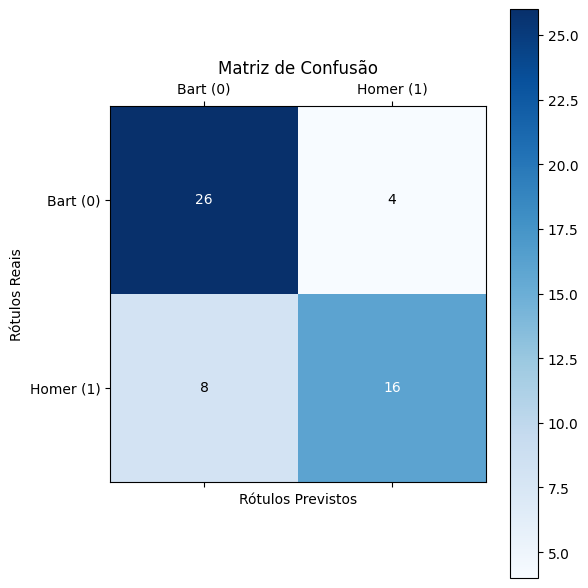

In [417]:
cm = confusion_matrix(last_targets, last_predictions, labels=[0, 1])


fig, ax = plt.subplots(figsize=(6, 6))
cax = ax.matshow(cm, cmap=plt.cm.Blues)
plt.colorbar(cax)

classes = ['Bart (0)', 'Homer (1)']
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
plt.xlabel('Rótulos Previstos')
plt.ylabel('Rótulos Reais')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.title('Matriz de Confusão')
plt.tight_layout()
plt.show()

# Testando Imagens
Após treino é possível visualizar as imagens classificadas com o valor real e o predict.

In [418]:
def predict_and_plot_image(model, dataset, image_index, class_names, device):
    #Carrega uma imagem pelo índice do dataset, prevê a classe e plota.

    model.eval()

    img_tensor, true_label = dataset[image_index]

    input_tensor = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        prediction_index = output.argmax(dim=1).item()

    predicted_class = class_names[prediction_index]
    true_class = class_names[true_label]

    file_path = dataset.files[image_index]
    original_img = Image.open(file_path).convert("L")

    plt.figure(figsize=(4, 4))
    plt.imshow(original_img, cmap='gray')

    title = f"Previsão: {predicted_class}\n (Real: {true_class})"

    color = "green" if predicted_class == true_class else "red"

    plt.title(title, color=color, fontsize=12)
    plt.axis('off')
    plt.show()


Testando índice 3 do conjunto de Validação/Teste.


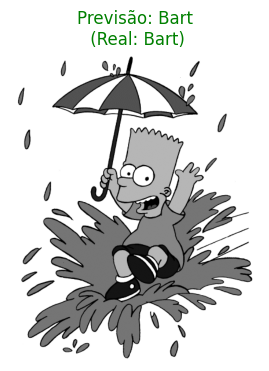

In [420]:
CLASS_NAMES = ['Bart', 'Homer']

#O índice deve ser do tamanho do teste max 54.
image_index_to_test = 3
print(f"Testando índice {image_index_to_test} do conjunto de Validação/Teste.")
global_index = val_dataset.indices[image_index_to_test]
predict_and_plot_image(model, dataset, global_index, CLASS_NAMES, device)